In [23]:
!pip install torchsampler
!pip install torchvision
!pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [24]:
import torch
import pandas as pd
import os

from torchvision.io import read_image
from torch.utils.data import Dataset

bean_annotations = pd.read_csv("../data/beans.csv")
bean_annotations.head()
DEFECT_CLASSES = dict(
    [
        (defect, index)
        for (index, defect) in enumerate(pd.unique(bean_annotations["defect_class"]))
    ]
)
DEFECT_CLASSES

{'burnt': 0,
 'normal': 1,
 'frag': 2,
 'under': 3,
 'quaker': 4,
 'insectOrMold': 5}

In [25]:
from torchvision.transforms import v2

transforms = {
    "train": v2.Compose(
        [
            v2.Resize(size=(400, 400)),
            v2.RandomHorizontalFlip(),
            v2.RandomRotation(
                degrees=(20, 340), fill=(255, 255, 255)
            ),  # Augment the data with random rotations, setting the background to white
            v2.ToDtype(
                torch.float32, scale=True
            ),  # Use float32 datatype to enable training on Apple silicon GPU
            v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    ),
    "test": v2.Compose(
        [
            v2.Resize(size=(400, 400)),
            v2.RandomRotation(
                degrees=(20, 340), fill=(255, 255, 255)
            ),  # Augment the data with random rotations, setting the background to white
            v2.ToDtype(torch.float32, scale=True),
            v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    ),
}

In [26]:
class RoastDefectsDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.bean_annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.bean_annotations)

    def get_labels(self):
        return self.bean_annotations["defect_class"]

    def __getitem__(self, item):
        if torch.is_tensor(item):
            item = item.toList()

        img_name = self.bean_annotations.iloc[item, 0]
        img_dir = "-".join(img_name.split("-")[0:4])
        img_path = os.path.join(self.root_dir, img_dir, img_name)
        image = read_image(img_path)

        if self.transform:
            image = self.transform(image)

        annotations = DEFECT_CLASSES[
            self.bean_annotations.iloc[item, 1:]["defect_class"]
        ]
        return image, annotations

In [27]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(
    bean_annotations,
    train_size=0.8,
    random_state=42,  # for repeatability
    stratify=bean_annotations["defect_class"],
)

In [28]:
train["defect_class"].value_counts()

defect_class
normal          1048
quaker           782
frag             237
under             83
burnt             40
insectOrMold      38
Name: count, dtype: int64

In [29]:
test["defect_class"].value_counts()

defect_class
normal          263
quaker          196
frag             59
under            21
burnt            10
insectOrMold      9
Name: count, dtype: int64

In [30]:
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchsampler import ImbalancedDatasetSampler

data_train = RoastDefectsDataset(
    csv_file="../data/beans.csv",
    root_dir="../data/processed-whitebg",
    transform=transforms["train"],
)

data_test = RoastDefectsDataset(
    csv_file="../data/beans.csv",
    root_dir="../data/processed-whitebg",
    transform=transforms["test"],
)

train_sampler = ImbalancedDatasetSampler(
    data_train, labels=train["defect_class"], indices=list(train.index)
)
test_sampler = SubsetRandomSampler(list(test.index))


train_loader = DataLoader(data_train, sampler=train_sampler, batch_size=4)
test_loader = DataLoader(data_test, sampler=test_sampler, batch_size=len(train))

dataloaders = {"test": test_loader, "train": train_loader}
dataset_sizes = {"test": len(test), "train": len(train)}
device = "cuda" if torch.cuda.is_available() else "cpu"

In [31]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    loss_history = {"train": [], "test": []}
    acc_history = {"train": [], "test": []}
    for epoch in range(num_epochs):
        print(f"Epoch {epoch}/{num_epochs - 1}")
        print("-" * 10)

        # Each epoch has a training and validation phase
        for phase in ["train", "test"]:
            if phase == "train":
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            all_labels = []
            all_preds = []

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                all_labels.extend(labels.tolist())

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    all_preds.extend(preds.tolist())

                    # backward + optimize only if in training phase
                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == "train" and scheduler is not None:
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            print(f"Correct guesses in phase {phase}: {running_corrects}")
            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
            acc_history[phase].append(epoch_acc)
            loss_history[phase].append(epoch_loss)
            # if phase == "test":
            #     acc_history['test'].append(epoch_acc)
            #     loss_history['test'].append(epoch_loss)
            # elif phase == 'train':
            #     acc_history['train'].append(epoch_acc)
            #     loss_history['train'].append(epoch_loss)

            # print("Classification report for test dataset:")
            # print(
            #     classification_report(
            #         all_labels,
            #         all_preds,
            #         target_names=DEFECT_CLASSES.keys(),
            #         zero_division=0,
            #     )
            # )
            print()
    return acc_history, loss_history

In [32]:
from torchvision import models


def get_resnet_50():
    model = models.resnet50(weights="IMAGENET1K_V2")
    last_layer_in_features = model.fc.in_features
    model.fc = torch.nn.Linear(last_layer_in_features, len(DEFECT_CLASSES))
    return model


def get_mobilenet(pretrained=False):
    model = models.mobilenet_v2(weights="IMAGENET1K_V1" if pretrained else None)
    last_layer_in_features = model.classifier[1].in_features
    model.fc = torch.nn.Linear(last_layer_in_features, len(DEFECT_CLASSES))
    return model


def get_resnet_34():
    model = models.resnet34(weights="IMAGENET1K_V1")
    last_layer_in_features = model.fc.in_features
    model.fc = torch.nn.Linear(last_layer_in_features, len(DEFECT_CLASSES))
    return model

In [33]:
import torch.nn as nn
from torch.optim import lr_scheduler

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

gridsearches = {}
for model_name in ["mobilenet_pt", "mobilenet", "resnet50"]:
    for optim in ["sgd", "adam"]:
        for lr in [0.0001, 0.001, 0.01]:
            if model_name == "mobilenet_pt":
                model = get_mobilenet(pretrained=True).to(device)
            elif model_name == "mobilenet":
                model = get_mobilenet(pretrained=False).to(device)
            elif model_name == "resnet50":
                model = get_resnet_50().to(device)
            experiment = f"model: {model_name}, optim: {optim}, lr: {lr}"
            print(experiment)
            optimizer = (
                torch.optim.SGD(model.parameters(), lr, momentum=0.9)
                if optim == "sgd"
                else torch.optim.Adam(model.parameters(), lr)
            )
            scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
            acc_hist, loss_hist = train_model(
                model, criterion, optimizer, scheduler, 30
            )
            gridsearches[experiment] = {"loss": loss_hist, "acc": acc_hist}

model: mobilenet_pt, optim: sgd, lr: 0.0001
Epoch 0/29
----------


KeyboardInterrupt: 

In [2]:
import json

with open("gridsearches.json", "r") as grid_file:
    completed_searches = json.load(grid_file)

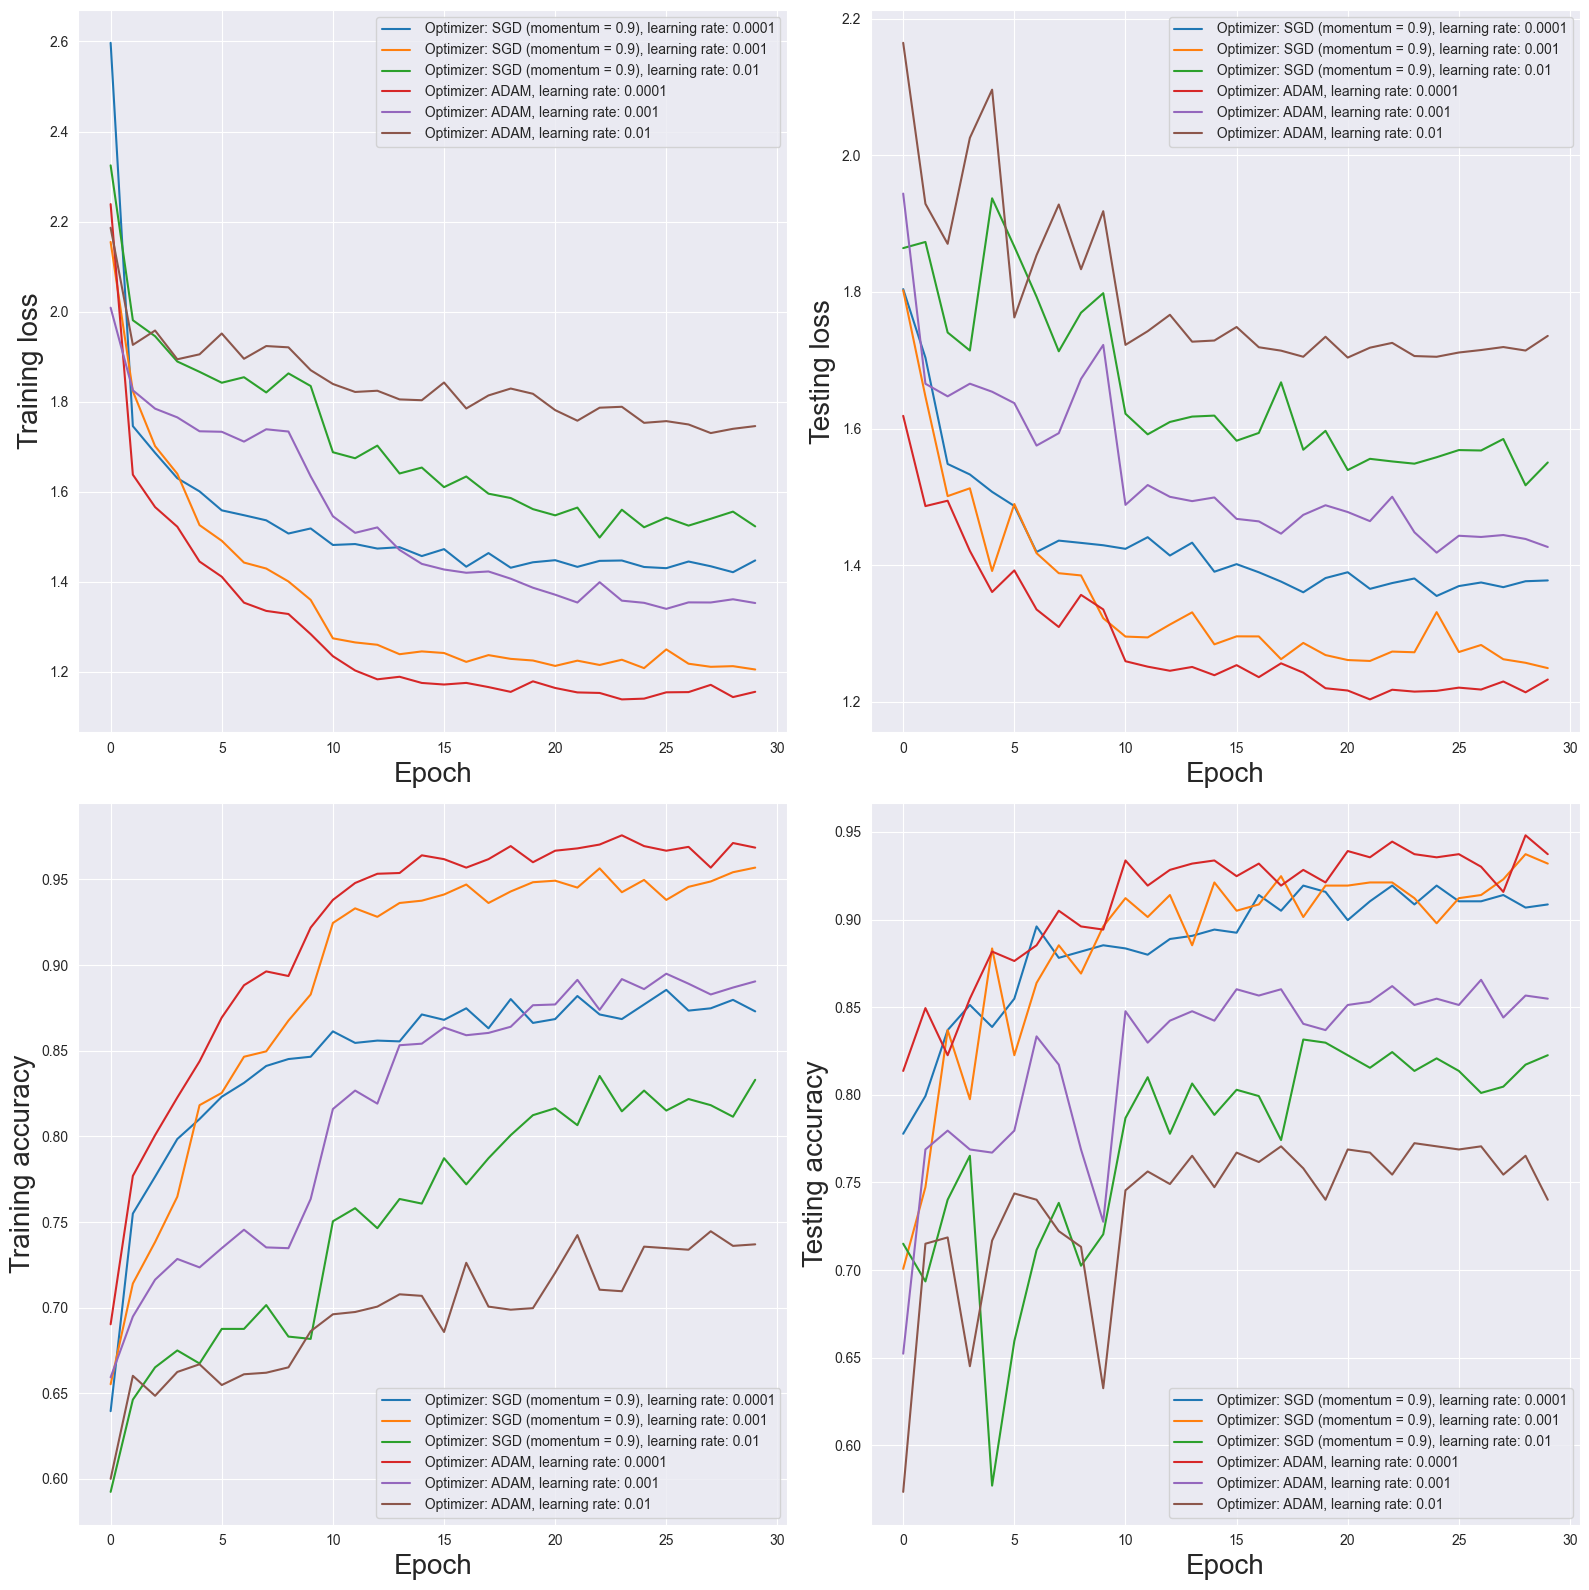

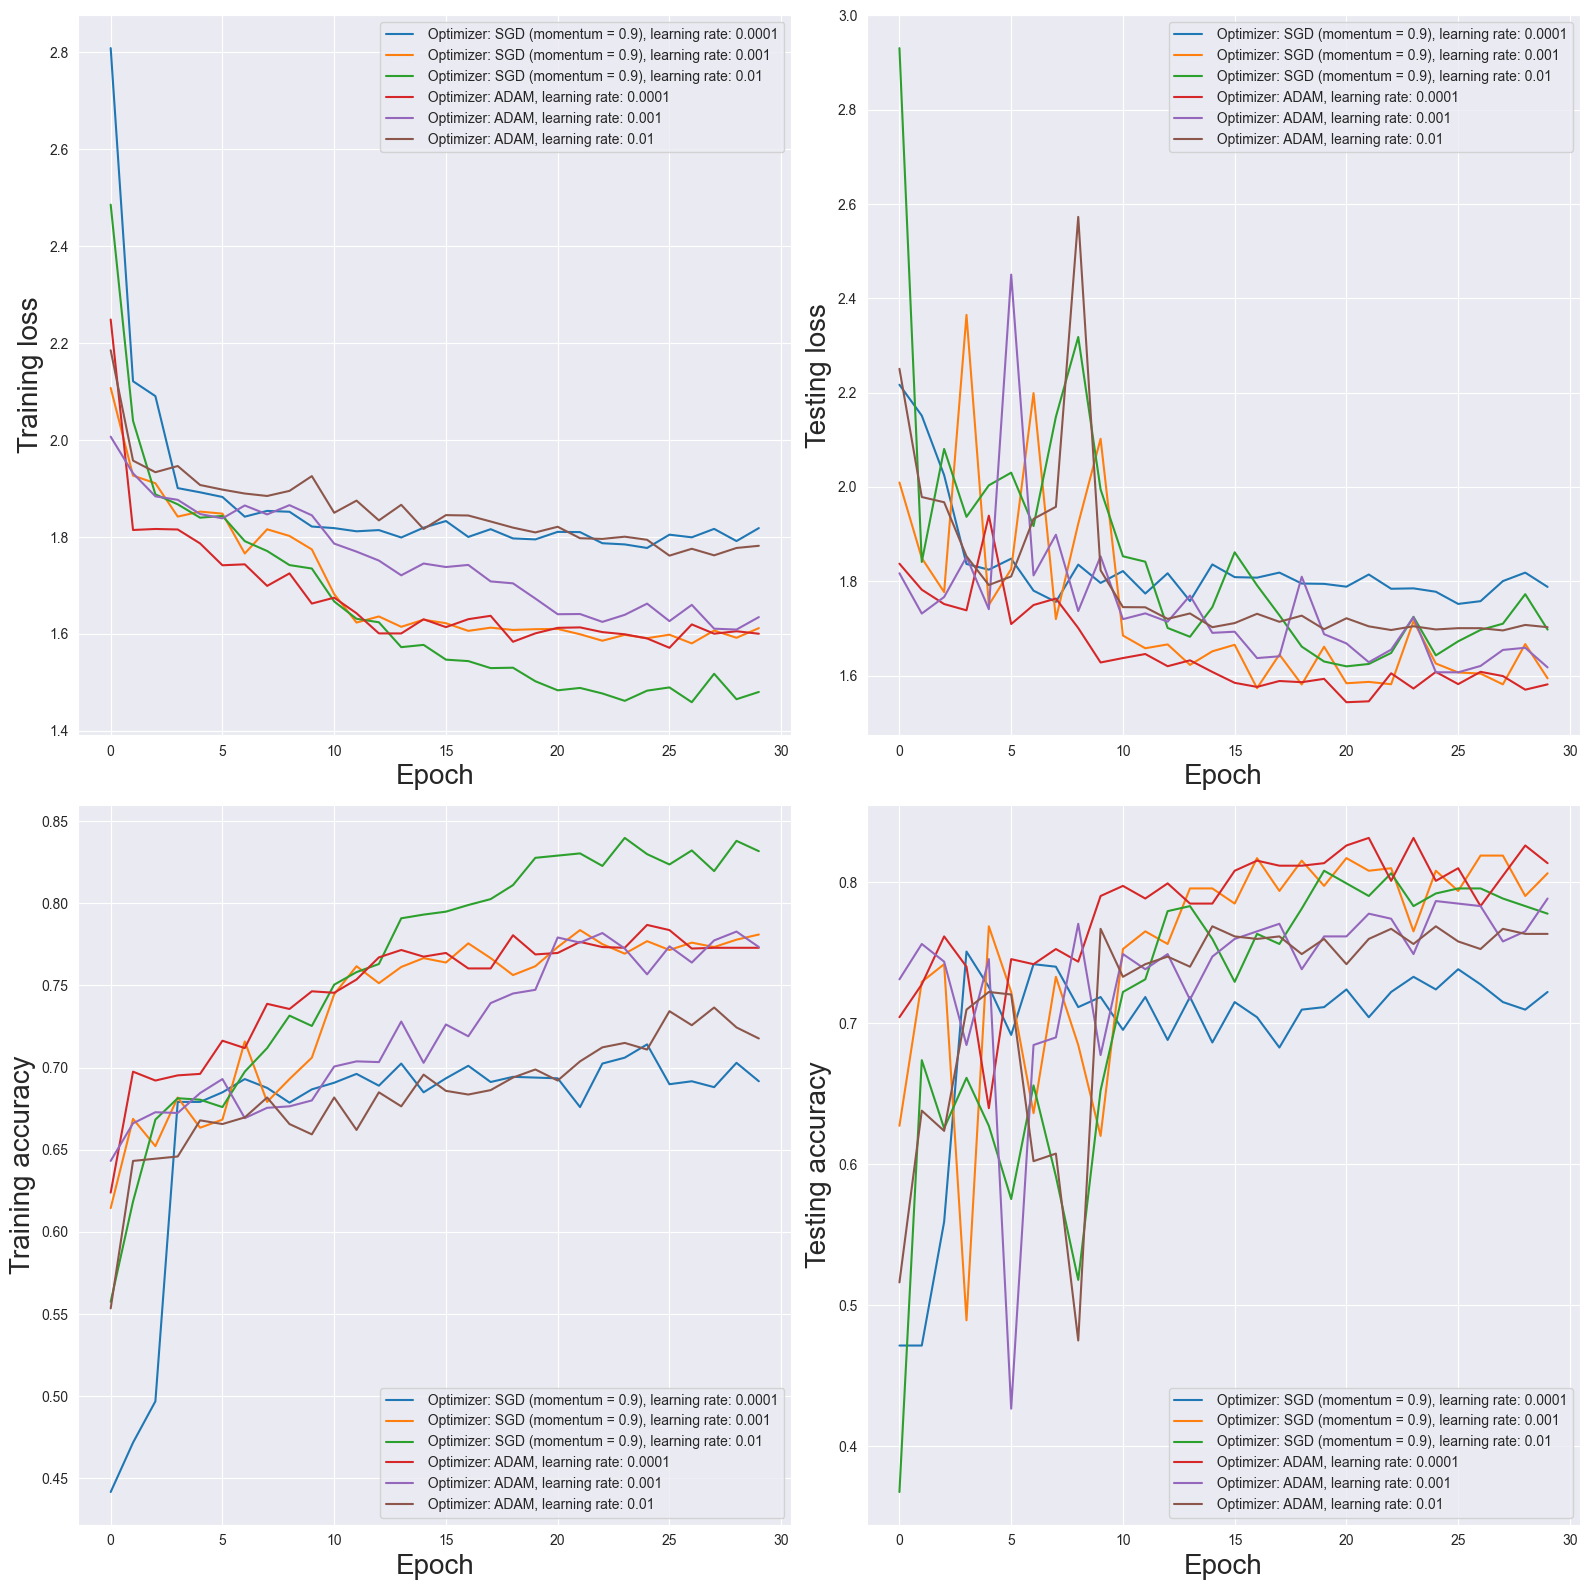

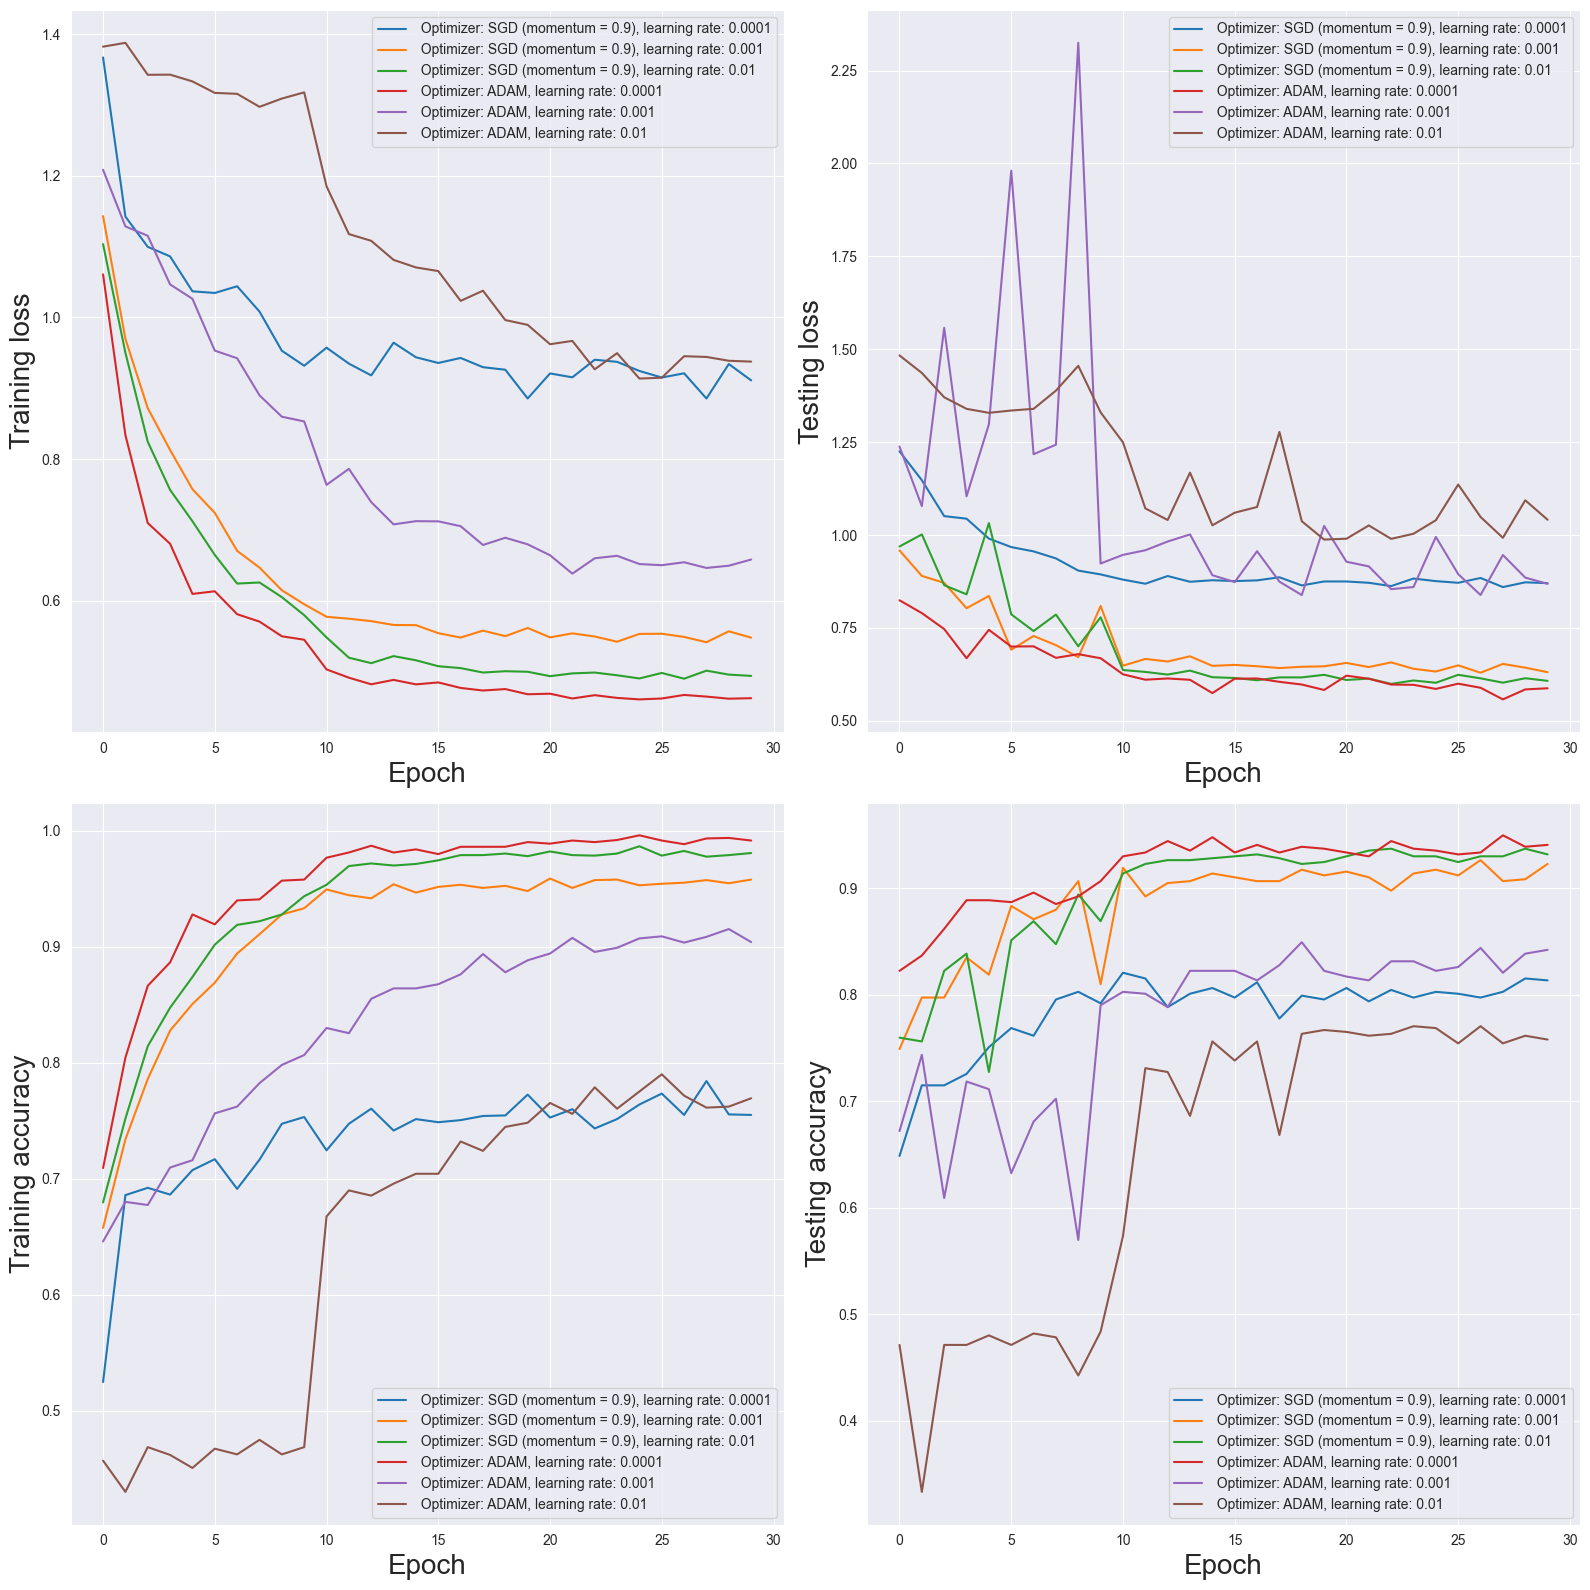

In [31]:
import matplotlib.pyplot as plt

# Create a dictionary to hold the subplots for each model
FONT_SIZE = 20
model_plots = {
    "mobilenet_pt": plt.subplots(2, 2, figsize=(16, 16)),
    "mobilenet": plt.subplots(2, 2, figsize=(16, 16)),
    "resnet50": plt.subplots(2, 2, figsize=(16, 16)),
}

for experiment, result in completed_searches.items():
    curve_label = ",".join(
        experiment.replace("optim", "Optimizer")
        .replace("adam", "ADAM")
        .replace("sgd", "SGD (momentum = 0.9)")
        .replace("lr", "learning rate")
        .split(",")[1:]
    )
    model_name = experiment.split(",")[0].split(": ")[1]
    fig, plots = model_plots[model_name]

    # Training loss
    plots[0, 0].plot(result["loss"]["train"], label=curve_label)
    plots[0, 0].legend()
    plots[0, 0].set_xlabel("Epoch", fontsize=FONT_SIZE)
    plots[0, 0].set_ylabel("Training loss", fontsize=FONT_SIZE)

    # Testing loss
    plots[0, 1].plot(result["loss"]["test"], label=curve_label)
    plots[0, 1].legend()
    plots[0, 1].set_xlabel("Epoch", fontsize=FONT_SIZE)
    plots[0, 1].set_ylabel("Testing loss", fontsize=FONT_SIZE)

    # Training accuracy
    plots[1, 0].plot(result["acc"]["train"], label=curve_label)
    plots[1, 0].legend()
    plots[1, 0].set_xlabel("Epoch", fontsize=FONT_SIZE)
    plots[1, 0].set_ylabel("Training accuracy", fontsize=FONT_SIZE)

    # Testing accuracy
    plots[1, 1].plot(result["acc"]["test"], label=curve_label)
    plots[1, 1].legend()
    plots[1, 1].set_xlabel("Epoch", fontsize=FONT_SIZE)
    plots[1, 1].set_ylabel("Testing accuracy", fontsize=FONT_SIZE)

    fig.tight_layout()
    fig.savefig(f"../report/figures/gridsearches/{model_name}.png", bbox_inches="tight")